<img style="float:right;" src="https://data.iflood.vse.gmu.edu/Forecast/ChesapeakeBay_XBEACH/pics_for_deal/labLogoFLOOD_black.png" width=300px>  
# XBeach Post Process


##### Abstract:
Coastal communities along the US mid-Atlantic region have been repeatedly affected by storm surge causing structural damage and flooding. Among different alternatives to prevent damages and flooding due to storm surge, natural and nature-based solutions, such as coastal marshes, are gaining importance as a form of coastal protection. Analysis of the data collected will be applied to coastal numerical models to replicate the nearshore physical processes in coastal marshes. We expect to develop engineering guidelines on the use of this nature based defenses for coastal protection against extreme events.  
<div align="middle">
<img style="float:center;" src="https://data.iflood.vse.gmu.edu/Forecast/ChesapeakeBay_XBEACH/pics_for_deal/Illustration%20of%20Nature%20Conservancy%20project%20site_02.jpg" width=1000px></div>

#### Initialize XBeach Libraries

In [1]:
import sys;sys.path.append('../xbeach/')
from importlib import reload
from libs import *
from scipy.io import loadmat
import xbeach
import utils
from IPython.display import IFrame
import matplotlib as mpl

#### Initialize Paths

In [2]:
root = pl.Path(r'Z:\Users\Tyler\projects\TNC\modeling\2d')
xb = nc4.Dataset(str(root / 'optimized_grid' / 'xboutput.nc'))
root2 = pl.Path(r'Z:\Project_TNC\3_Field\2_Data\2_Processed')
hobos = root2 / '1_hobo' / 'di_20180912_20181205'

#### Initialize Variables

In [3]:
x,y = xbeach.utm2geo(xb.variables['globalx'][:,:],xb.variables['globaly'][:,:])
z = xb.variables['zb'][:,:,:]
t = xb.variables['meantime'][:]
zs = xb.variables['zs'][:,:,:]
h = xb.variables['H'][:,:,:]
u = xb.variables['u'][:]
v = xb.variables['v'][:]

In [4]:
x2,y2 = xb.variables['globalx'][:,:],xb.variables['globaly'][:,:]

#### Show grid and bathy of Study Site

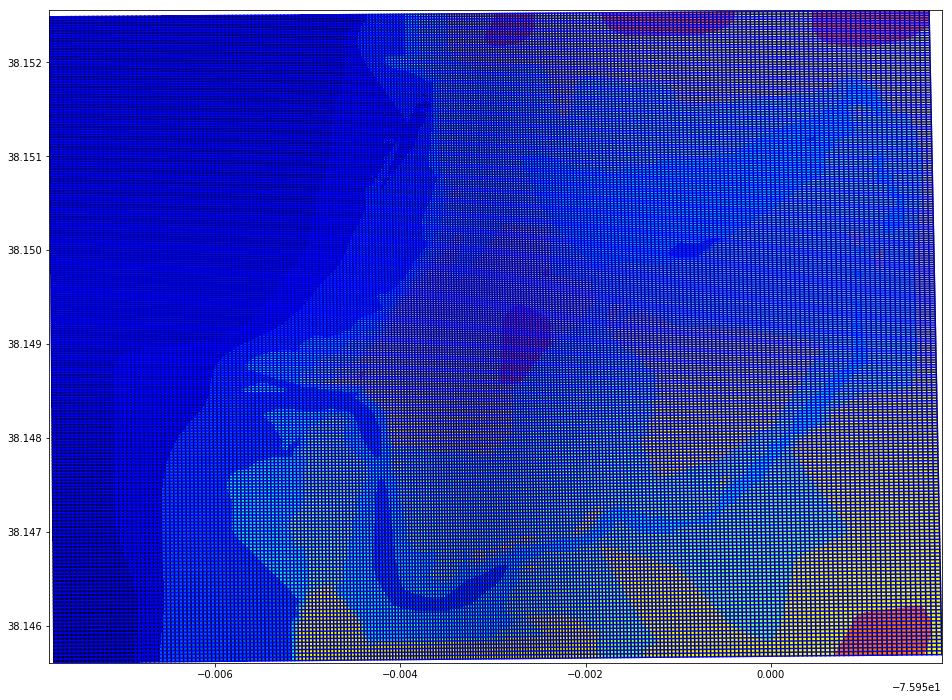

In [5]:
fig,ax = plt.subplots(figsize=(16,12))
ax.plot(x,y,'k')
ax.plot(x.transpose(),y.transpose(),'b')
ax.contourf(x,y,z[0,:,:],cmap='jet',vmin=-1.5,vmax=2)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
plt.show()

In [28]:
m = xbeach.interactive_grid(38.15,-75.9,y,x,z[0,:,:])
m.save(outfile='map.html')
IFrame('map.html', width=900, height=650)

In [11]:
xx,yy = x.shape
vege = np.zeros((xx,yy))
bed  = np.zeros((xx,yy))
z0 = z[0,:,:]

In [12]:
mannings = [0.027,0.02,0.025,0.100]#channel,ocean,marsh, tree
v_heights = [1,2,3,0]#marsh,beach,tress,none
x1,y1 = x.shape
for i in range(0,x1):
    for ii in range(0,y1):
        if z0[i,ii]<-.01 and x[i,ii]>-75.955 and y[i,ii]<38.1485:
            bed[i,ii] = mannings[0]
        elif .05 < z0[i,ii] < 0.6 and -75.955 < x[i,ii] < -75.954 and 38.1487<y[i,ii]<38.1495:
            vege[i,ii] = v_heights[1]
        elif z0[i,ii]<-.01 and x[i,ii]>-75.95325:
            bed[i,ii] = mannings[0]
        elif -0.05<z0[i,ii]<0.7 and x[i,ii]>-75.955:
            bed[i,ii] = mannings[2]
            vege[i,ii]=v_heights[0]
        elif z0[i,ii]>0.7:
            bed[i,ii] = mannings[3]
            vege[i,ii]=v_heights[2]
        else:
            bed[i,ii] = mannings[1]
            vege[i,ii]=v_heights[3]



In [8]:
write_2delft(root,vege,'temp.txt')

NameError: name 'write_2delft' is not defined

In [9]:
write_2delft(root,bed,'bedfrict.txt')

NameError: name 'write_2delft' is not defined

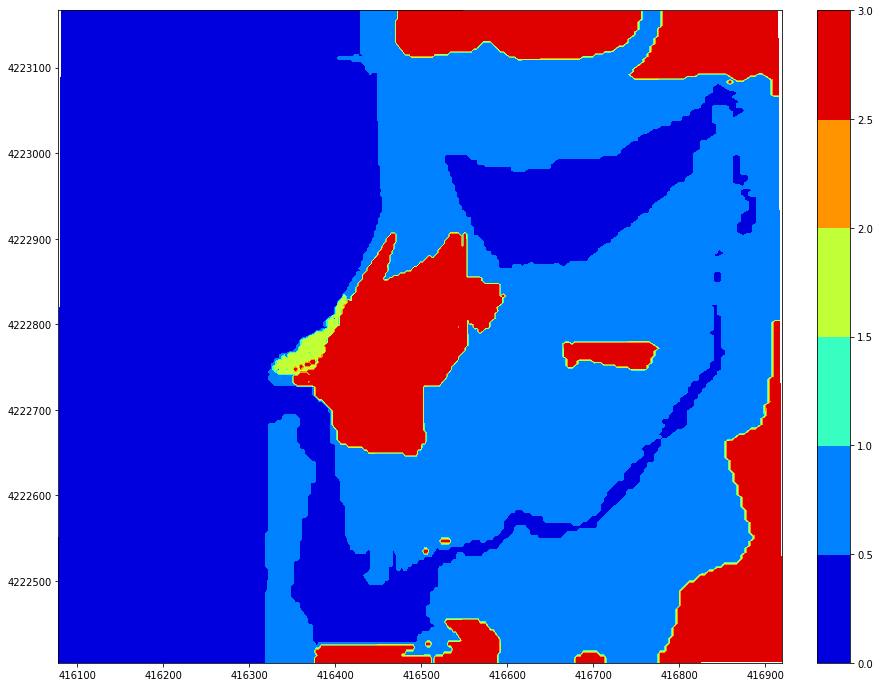

In [15]:
fig,ax = plt.subplots(figsize=(16,12))
levels = np.arange(0,3.1,.5)
plt.contourf(x2,y2,vege[:,:],cmap='jet',vmin=0,vmax=np.max(levels),levels=levels)
plt.colorbar(cmap='jet',pad=0.04)
#ax.set_xlim([x.min(),x.max()])
#ax.set_ylim([y.min(),y.max()])
plt.show()

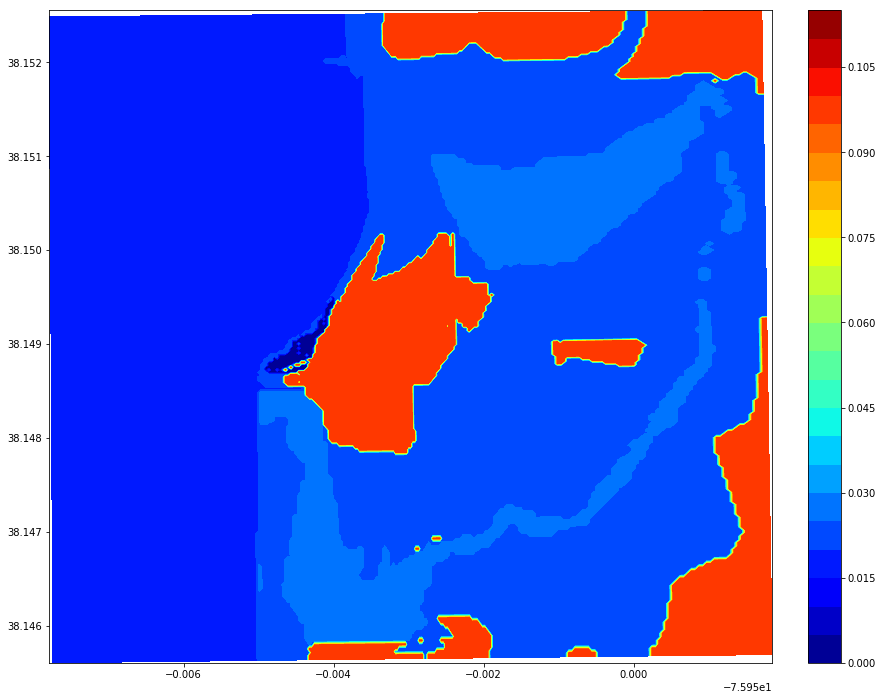

In [16]:
fig,ax = plt.subplots(figsize=(16,12))
#cmap = mpl.cm.get_cmap('jet')  
#normalize = mpl.colors.Normalize(vmin=.01, vmax=.03)
#colors = [cmap(normalize(value)) for value in bed.reshape(x1*y1)]
levels = np.arange(0,0.12,0.005)
plt.contourf(x,y,bed,cmap='jet',vmin=0, vmax=np.max(levels),levels=levels)
plt.colorbar(cmap='jet',pad=0.04)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
plt.show()

#### Create 2d contour map

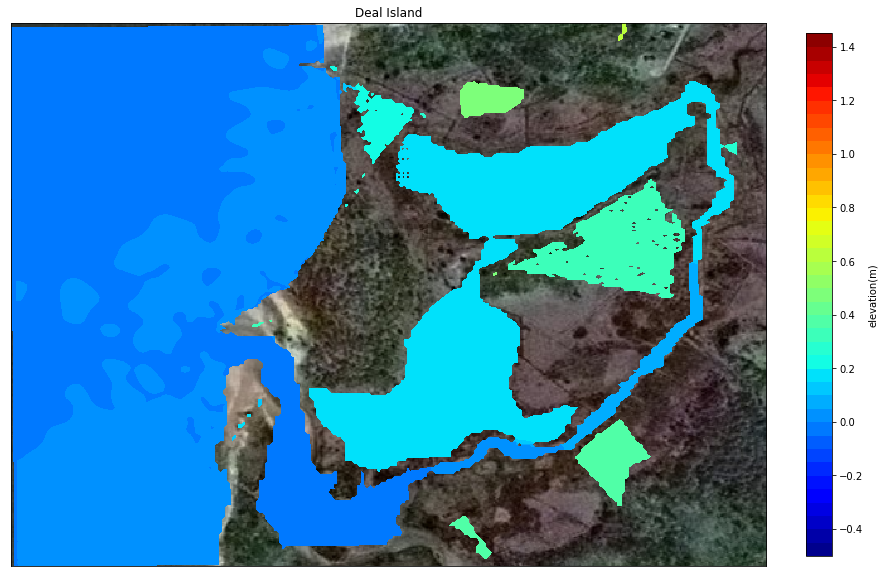

In [17]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.5,1.5,0.05)
xbeach.contour_map(x,y,z[0,:,:],zs[50,:,:],title,levels,lat1,lat2,lon1,lon2)

#### Find Observation Stations

In [18]:
station_x = [-75.953653,-75.953486,-75.953338,-75.952953] # s1,s2,s3,s4
station_y = [38.151136,38.151207,38.151208,38.151215]
gridx,gridy = [], []
for i in range(0,4):
    node = xbeach.find_node_ak(x,y,station_y[i],station_x[i])
    gridx.append(node[0])
    gridy.append(node[1])

#### Generate Model stations

In [19]:
water = xbeach.correct_hobo(str(hobos / 't1.mat'))
time = pd.date_range(start=pd.to_datetime('2018-09-12 19'),periods=int(len(zs[:,gridx[0],gridy[0]])),freq='20min')
model = pd.DataFrame({'date time':time,'s1':zs[:,gridx[0],gridy[0]],'s2':zs[:,gridx[1],gridy[1]],
                      's3':zs[:,gridx[2],gridy[2]],'s4':zs[:,gridx[3],gridy[3]]})

#### Generate 2d contour video with observation stations

In [ ]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.3,2,0.1)
start,time = '2018091219', 280 
title = 'Deal Island '
xbeach.contour_stations(x,y,zs,water,gridx,gridy,model,start,time,title,levels,lat1,lat2,lon1,lon2)

<div align="middle"><img style="float:center;" src="xbeach2d.gif" width=1000px></div>

#### Generate 3d video

In [ ]:
title = 'Deal Island'
levels = np.arange(-0.3,1.50001,0.1)
start,time = '2018091219',280
title = 'Deal Island '
xbeach.video_3d(x,y,z,h+zs,start,time,title,levels)

<div align="middle"><img style="float:center;" src="xbeach3d.gif" width=900px></div>

#### Generate Contour video with velocity vectors

In [ ]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.3,1.5,0.1)
start,time = '2018091219',280
xbeach.map_velocity(x,y,zs,u,v,start,time,title,levels,lat1,lat2,lon1,lon2,gridspace=75)

<div align="middle"><img style="float:center;" src="xbeach_velocity.gif" width=900px></div>

#### Max velocity in the model

In [7]:
np.max(np.sqrt(np.square(u)+np.square(v)))

0.6554845707896482